In [1]:
import numpy as np
import scipy as sci
from scipy.constants import hbar 
import time
import scipy.linalg
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [2]:
def getExactEigenvalue(m, R, mass):
    return (hbar**2 * m**2) / (2 * mass * R**2)

In [3]:
class ParticleRing:
    
    def __init__(self, h, timingInt):
        self.h = h
        self.timingInt = timingInt
        self.x_max = 10.0
        self.x = np.arange(0, 2*np.pi, h)
        self.kinetic = self.second_derivative_matrix()
        self.position = self.angular_position_matrix()
        
    def xShape(self):
        # This is used for creating the m matrix later on, but doesn't play much of a role in finding the solutions. 
        return self.x, self.x.shape[0]

    def second_derivative_matrix(self):
        # We create the second derivative (kinetic energy) matrix here. 
        N = len(self.x)
        dx = self.x[1] - self.x[0]

        # Generate the matrix for the second derivative using a five-point stencil
        main_diag = np.ones(N) * (-5.0 / 2 / dx**2)
        off_diag = np.ones(N - 1) * 4 / 3 / dx**2
        off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))

        D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(
            off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)

        return D2

    def angular_position_matrix(self):
        return np.diag(self.x)
    
    def creator(self, R):
        return - (hbar**2) / (2 * R**2) * self.kinetic + self.position

    def timing(self, H):
        """
        In the timing function, we solve the solution many times and get the average of the times. 
        This helps to boost the accuracy of the time value. The timingInt value determines how many times to collect. 
        """
        solveTime = []
        for i in range(self.timingInt):
            time0 = time.time()
            evals, evects = np.linalg.eigh(H)
            time1 = time.time()
            solveTime.append(time1 - time0)
        avg = sum(solveTime) / len(solveTime)
        return avg

    def solver(self,R):
        # We use the numpy linalg.eigh function to solve for the eigenvalues and eigenvectors of the matrix. 
        H = self.creator(R)
        evals, evects = np.linalg.eigh(H)
        solveTime = self.timing(H)
        evects = evects.T
        m_val = evects[0] / np.linalg.norm(evects[0])*np.sign(evects[0][  int(len(self.x)/2) ])
        return evals, evects, solveTime, m_val


In [4]:
hList = [1/10, 1/20, 1/10]
radii = np.arange(.5,10.5,.5)
timingInt = 10
herrors = []
htimes = []
m_1 = 1
mass = 1.0

for h in hList:
    ParicleRingInstance = ParticleRing(h, timingInt)
    for rad in radii:
        evals, evects, solveTime, m_val = ParicleRingInstance.solver(rad)
        htimes.append(solveTime)
        herrors.append(np.abs(getExactEigenvalue(m_1,rad,mass)-evals[0]))

In [5]:
h = (2 * np.pi) / (201)
ParicleRingInstance = ParticleRing(h, timingInt)
x, x_shape = ParicleRingInstance.xShape()
m = np.zeros((len(radii), x_shape))
for i in range(len(radii)):
    evals, evects, solveTime, m_val = ParicleRingInstance.solver(radii[i])
    m[i] = m_val

In [6]:
herrors

[5.53836615849612e-66,
 1.38459153962403e-66,
 6.153740176106799e-67,
 3.461478849060075e-67,
 2.215346463398448e-67,
 1.5384350440266997e-67,
 1.130278807856351e-67,
 8.653697122650187e-68,
 6.837489084563111e-68,
 5.53836615849612e-68,
 4.577162114459603e-68,
 3.846087610066749e-68,
 3.2771397387551e-68,
 2.8256970196408777e-68,
 2.4614960704427204e-68,
 2.1634242806625467e-68,
 1.9163896742201106e-68,
 1.7093722711407777e-68,
 1.5341734511069585e-68,
 1.38459153962403e-68,
 2.2220191937098887e-65,
 5.555047984274722e-66,
 2.46891021523321e-66,
 1.3887619960686804e-66,
 8.888076774839557e-67,
 6.172275538083025e-67,
 4.534733048387529e-67,
 3.471904990171701e-67,
 2.7432335724813446e-67,
 2.2220191937098892e-67,
 1.8363794989337927e-67,
 1.5430688845207562e-67,
 1.3148042566330704e-67,
 1.1336832620968822e-67,
 9.875640860932842e-68,
 8.679762475429253e-68,
 7.688647729099961e-68,
 6.858083931203361e-68,
 6.15517782191105e-68,
 5.555047984274723e-68,
 5.53836615849612e-66,
 1.3845915

/tmp/ipykernel_2702/592868258.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  catAx.set(xscale='log',yscale='log',


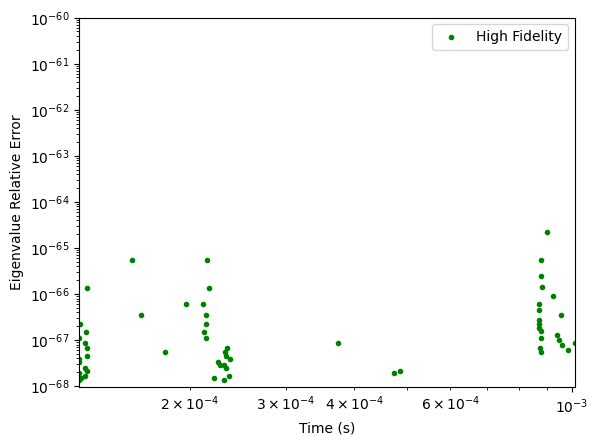

In [7]:
maxT = max(htimes) + 10**-60
minT = min(htimes)- 10**-60
maxEr = max(herrors)+ 10**-60
minEr = min(herrors)- 10**-60

catFig, catAx = plt.subplots()

catAx.scatter(htimes,herrors,color='green',
               marker='.',label='High Fidelity')

catAx.set(xscale='log',yscale='log',
           xlabel='Time (s)',ylabel='Eigenvalue Relative Error',
           xlim=(minT, maxT),ylim=(minEr,maxEr))

plt.legend()
plt.show()

In [22]:
class RBM:
    def __init__(self, h, m, components):
        # Since we create the kinetic and potential energy terms, we use the h value
        self.m = m
        self.h = h
        self.components = components
        self.psi = np.array(self.getReducedBasis())
        self.phi = self.psi
        self.x_max = 10.0
        self.x = np.arange(-self.x_max, self.x_max + h, h)
        self.d2 = self.second_derivative_matrix()
        self.pot = self.potential_matrix()
        self.compvec = np.zeros(components)
        self.array = self.create_array()
        self.M_0 = np.array(self.array)
        self.M_1 = np.array(self.array)
        self.N = np.array(self.array)

    def create_array(self):
        # We use this to create a component x component long matrix
        array = []
        for i in range(self.components):
            array.append(self.compvec)
        return array
    
    def second_derivative_matrix(self):
        # Once again, we create the second derivative matrix
        size = len(self.x)
        offDiag = np.zeros(size)
        offDiag[1] = 1
        
        H = -1*(-2*np.identity(size) + scipy.linalg.toeplitz(offDiag))/self.h**2
        return H

    def potential_matrix(self):
        # We create the potential energy matrix
        return np.diag(self.x**2)

    def getReducedBasis(self):
        # We apply SVD to get the reduced basis based on the number of components
        U, sigma, Vh = np.linalg.svd(self.m)
        reduced_basis = Vh[:self.components]
        return reduced_basis
    
    # Below we create the four matrices that we need, using np.dot to get the dot product between the phi and psi list
    def M0(self, i, j):
        M0 = np.dot(self.psi[j], np.dot(self.d2, self.phi[i]))
        return M0

    def M1(self, i, j):
        M1 = np.dot(self.psi[j], np.dot(self.pot, self.phi[i]))
        return M1
    
    # Note that this function takes in the radii parameter 
    def create_H_hat(self):
        for i in range(self.components):
            for j in range(i, self.components):
                self.M_0[i][j] = self.phi[i] @ self.d2 @ self.psi[j]
                self.M_0[j][i] = self.M_0[i][j]
                self.M_1[i][j] = self.phi[i] @ self.pot @ self.psi[j]
                self.M_1[j][i] = self.M_1[i][j]
        H_hat = self.M_0 + self.M_1
        return H_hat
    
    def create_N(self):
        for i in range(self.components):
            for j in range(i, self.components):
                self.N[i,j] = self.phi[i] @ self.psi[j]
                self.N[j,i] = self.N[i,j]

    # Note that this function takes in the alpha parameter to pass it on to the create_H_hat() function
    def RBM_solve(self):
        H_hat = self.create_H_hat()
        self.create_N()
        evals, evects = scipy.linalg.eigh(H_hat, b=self.N)
        return evals, evects

In [23]:
radii = np.arange(.5,10.5,.5)
# h = (2 * np.pi) / (201)
h = 10**-1
components = 6
RBM_instance = RBM(h, m, components)
for i in range(len(radii)):
     # evals, evects = RBM_instance.RBM_solve(radii[i])
     evals, evects = RBM_instance.RBM_solve()
     print(evals[0])

114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763
114.77610971551763


In [24]:
radii = np.arange(.5,10.5,.5)
h = 10**-1
errors = []
times = []

for comp in range(3,7):
  RBM_instance = RBM(h, m, comp)
  for radius in radii:
    time1 = time.time()
    evals, evects = RBM_instance.RBM_solve(radii)
    time2 = time.time()
    timeDif = time2 -time1

    value = evals[0]
    errorDif = abs(getExactEigenvalue(radii)-value)

    times.append(timeDif)
    errors.append(errorDif)

maxT = max(htimes) + 10
minT = min(htimes) - 10
maxEr = max(errors) + 10
minEr = min(errors) - 10

catFig, catAx = plt.subplots()

catAx.scatter(times,errors,color='blue',
               marker='.',label='RBM')
catAx.scatter(htimes,herrors,color='green',
               marker='.',label='High Fidelity')

catAx.set(xscale='log',yscale='log',
           xlabel='Time (s)',ylabel='Eigenvalue Relative Error',
           xlim=(minT, maxT),ylim=(minEr,maxEr))

plt.legend()
plt.show()

TypeError: RBM.RBM_solve() takes 1 positional argument but 2 were given